In [127]:
import tensorflow as tf

In [128]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# X_train.shape
X_valid, y_valid = X_train[50000:], y_train[50000:]
X_train[0][1] # IT is numpy form

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8)

In [129]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [130]:
from tensorflow.train import  Example, Feature, Features, BytesList, Int64List# type: ignore
def convert_to_Example(record):
    image, label = record
    b_image = tf.io.serialize_tensor(image)
    example = Example(
        features=Features(
            feature={'image':Feature(bytes_list= BytesList(value=[b_image.numpy()])),
                 'label' : Feature(int64_list=Int64List(value=[label]))
                    }
                )
            )
    return example

In [131]:
def save_to_tfrecord(path, dataset):
    writer = tf.io.TFRecordWriter(path)
    for record in dataset:
        example = convert_to_Example(record).SerializeToString()
        writer.write(example)
        

In [132]:
train_filename = r'.\records_data\train.record'
test_filename = r'.\records_data\test.record'
valid_filename = r'.\records_data\valid.record'

In [133]:
train_dataset = train_dataset.shuffle(50000).prefetch(1)
save_to_tfrecord(train_filename, train_dataset)

In [134]:
test_dataset = test_dataset.prefetch(1)
save_to_tfrecord(test_filename, test_dataset)
valid_dataset = valid_dataset.prefetch(1)
save_to_tfrecord(valid_filename, valid_dataset)

In [135]:
train_record_dataset = tf.data.TFRecordDataset(train_filename)
test_record_dataset = tf.data.TFRecordDataset(test_filename)
valid_record_dataset = tf.data.TFRecordDataset(valid_filename)

In [136]:
record_description = {
    'image':tf.io.FixedLenFeature([], tf.string,default_value=''),
    'label':tf.io.FixedLenFeature([], tf.int64, default_value=1)
}
def parse(tfrecord):
    example = tf.io.parse_single_example(tfrecord,record_description)
    image = tf.io.parse_tensor(example['image'],out_type=tf.uint8)
    image = tf.reshape(image, (28,28))
    label = example['label']
    return image, label

In [137]:
def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [138]:
train_record_dataset = mnist_dataset(train_filename, shuffle_buffer_size=50000)
test_record_dataset = mnist_dataset(test_filename)
valid_record_dataset = mnist_dataset(valid_filename)

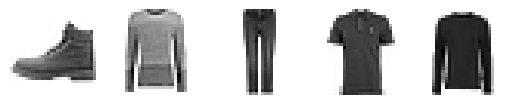

In [143]:
import matplotlib.pyplot as plt
for imgbatch, lblbatch in valid_record_dataset:
    for i in range(5):
        # print(tf.shape(imgbatch[i]))
        img = imgbatch[i]
        plt.subplot(1,5,i+1)
        plt.imshow(img, cmap='binary')
        plt.axis('off')
        
    break